In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from F_model import show_plot

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
# Load data
df = pd.read_csv('data/generated data/df_500.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df['qs'].fillna(method='ffill', inplace=True)
df['qs'][0] = 0.79
df['batch_id'] = df['batch_id'].astype(str).str.zfill(3)

In [4]:
# check of all NaN are removed
df.isna().sum()

time        0
biomass     0
glucose     0
batch_id    0
qs          0
dtype: int64

In [5]:
## Normalization batch by batch
#scaler = MinMaxScaler()
#b_unique = df['batch_id'].unique()
#df_norm = pd.DataFrame()
#for b in b_unique:
    #df_1b = df[df['batch_id'] == b]
    #df_1b.drop(['time', 'batch_id'], axis=1, inplace=True)
    #df_1b_scaled = scaler.fit_transform(df_1b)
    #df_1b = pd.DataFrame(df_1b_scaled, columns=df_1b.columns)  # Convert back to DataFrame
    #df_1b['time'] = df[df['batch_id'] == b]['time']  # Restore 'time' column
    #df_1b['batch_id'] = df[df['batch_id'] == b]['batch_id']
    #df_norm = pd.concat([df_norm, df_1b])
#df_norm.reset_index(drop=True, inplace=True)
#df_norm.shape

In [6]:
# Normalization for the whole dataframe
scaler = MinMaxScaler()
df_norm = df.drop(['time', 'batch_id'], axis=1).copy()
df_norm[df_norm.columns] = scaler.fit_transform(df_norm[df_norm.columns])
df_norm['time'] = df['time']
df_norm['batch_id'] = df['batch_id']

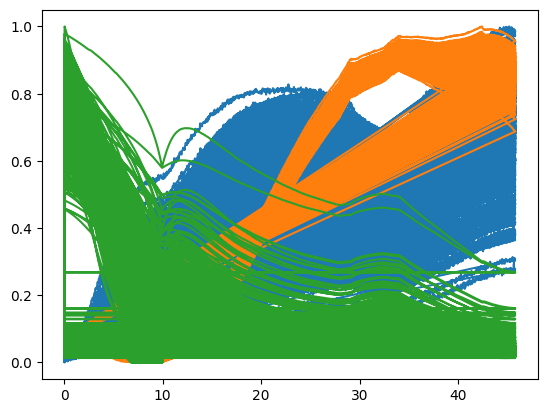

In [7]:
plt.plot(df_norm['time'], df_norm['biomass'])
plt.plot(df_norm['time'], df_norm['glucose'])
plt.plot(df_norm['time'], df_norm['qs'])

In [8]:
# group the df by batch_id and take the maximum value of qs
## output is an array (shape: [50,2]) which contains all unique batch_ids and a corresponding max qs
# based on the mean value a binary col is created
## when splitting the data in train & test it is ensured that high and low values of qs are equally distributed
df_grouped = df_norm.groupby('batch_id')['qs'].max().reset_index()
mean_qs = df_grouped['qs'].mean()
df_grouped['bin'] = df_grouped['qs'].apply(lambda x: 1 if x > mean_qs else 0)

In [9]:
# Split in the list of unique batch_ids into train and test
## I take the batch_ids instead of the whole dataset because otherwise snippets of one batch can be in
## both train and test set
## result is better because it has already seen the data
b_train, b_test = train_test_split(df_grouped, test_size=0.2, stratify=df_grouped['bin'], random_state=42)

In [10]:
# check how many 1 and 0 are in each group
print(np.unique(b_train['bin'], return_counts=True))
print(np.unique(b_test['bin'], return_counts=True))

(array([0, 1], dtype=int64), array([201, 199], dtype=int64))
(array([0, 1], dtype=int64), array([50, 50], dtype=int64))


In [11]:
b_train = list(b_train['batch_id'].values)
b_test = list(b_test['batch_id'].values)

In [12]:
df_train = df[df['batch_id'].isin(b_train)]
df_test = df[df['batch_id'].isin(b_test)]

In [13]:
# Define X and y
X_train = df_train.copy().drop(['qs'], axis=1)
y_train = df_train['qs'].values

X_test = df_test.copy().drop(['qs'], axis=1)
y_test = df_test['qs'].values

In [14]:
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=15 ,random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the testing data
y_pred = model.predict(X_test)

# Step 5: Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0014972037841381413


**Feature Importance**: Determining the importance or contribution of features in the model's predictions is a common interpretability technique. Random Forest models provide feature importances, which indicate the relative importance of each feature based on how much they contribute to reducing the impurity in the trees. Feature importances can help identify the most influential features and understand their impact on the model's predictions.

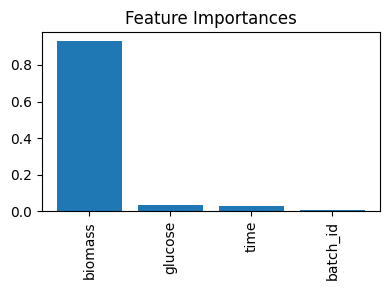

In [15]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order

# Plot feature importances
plt.figure(figsize=(4, 3))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [16]:
df_test_result = pd.DataFrame(X_test, columns=X_test.columns)
df_test_result['qs'] = y_test
df_test_result['qs_predicted'] = y_pred

print(b_test[:10])

['185', '230', '208', '292', '384', '431', '277', '300', '094', '165']


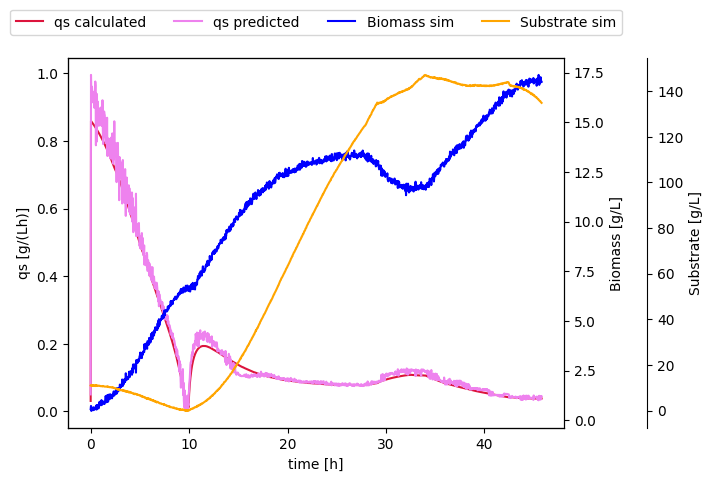

In [17]:
df_one = df_test_result[df_test_result['batch_id'] == '300']
show_plot(df_one)